In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import keras
from keras_unet.models import custom_unet
from sklearn.model_selection import train_test_split

2023-02-17 16:37:26.713437: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/Nathan Arnett Calcification'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [4]:
images = np.load(images_file)
labels = np.load(labels_file)

In [10]:
images.shape

(503, 512, 512)

In [5]:
images.ndim, labels.ndim

(3, 3)

In [6]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [7]:
p = np.random.permutation(len(images))

In [8]:
images = images[p]
labels = labels[p]

In [9]:
images = images.astype(np.float64)
labels = labels.astype(np.float64)

In [10]:
for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [11]:
images.shape

(503, 512, 512, 1)

In [12]:
labels.shape

(503, 512, 512, 1)

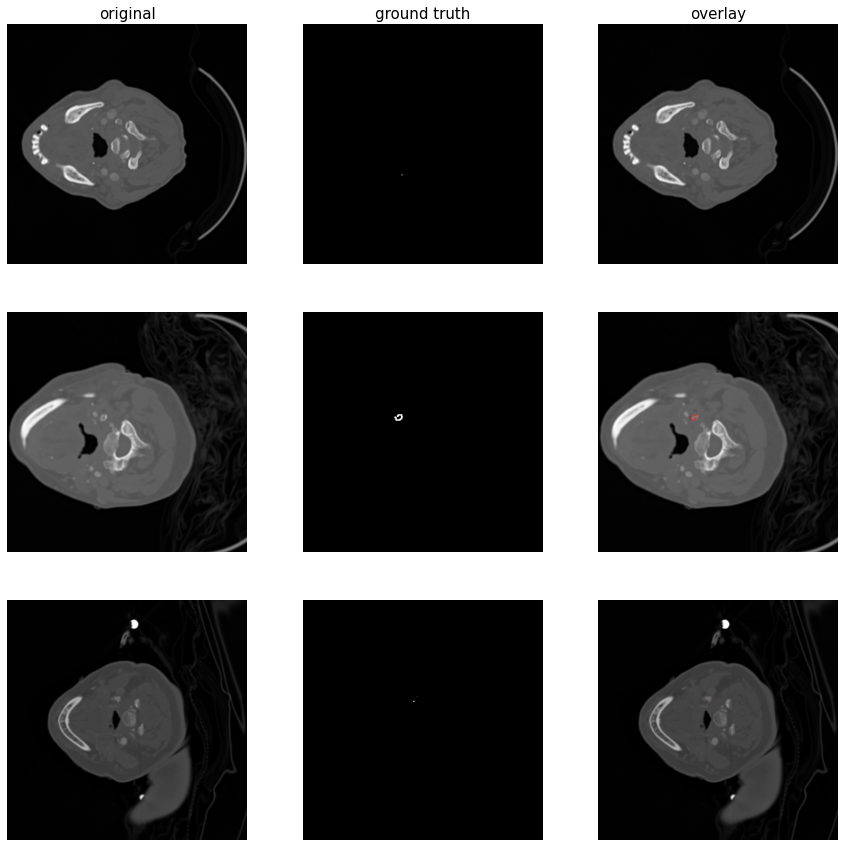

In [13]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=images, mask_imgs=labels, nm_img_to_plot=3, figsize=5)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=0)

In [15]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

(2, 512, 512, 1) (2, 512, 512, 1)


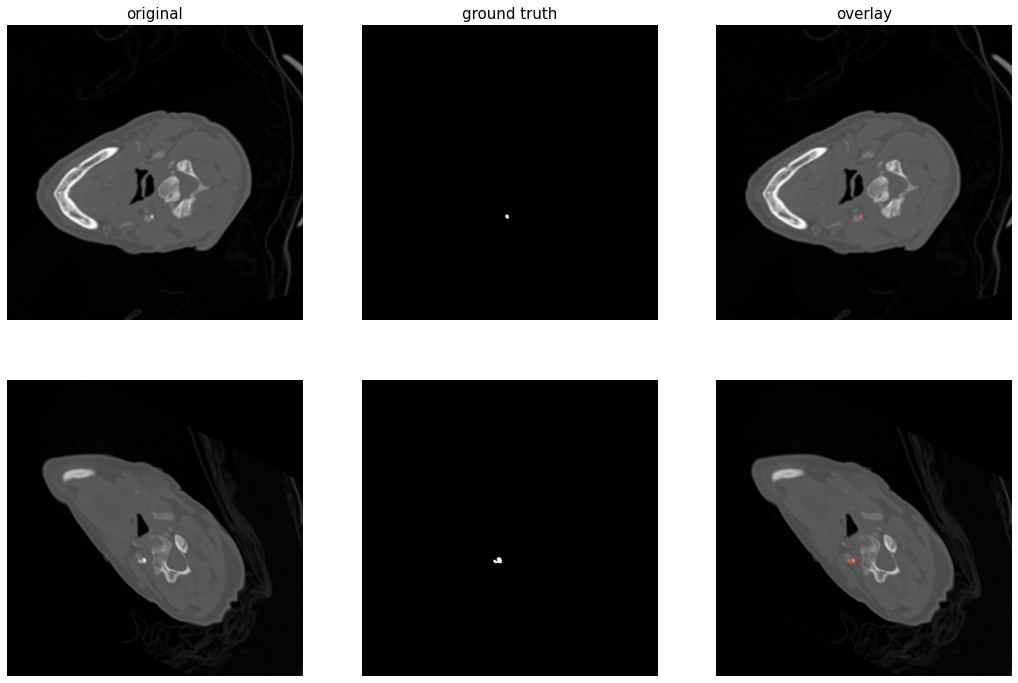

In [16]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [17]:
from keras_unet_collection import models, losses
import torch

model = models.swin_unet_2d((512, 512, 1), filter_num_begin=64,
                               n_labels=1, depth=4, stack_num_down=4, stack_num_up=4,
                               patch_size=(4, 4), num_heads=[4, 8, 16, 16],
                               window_size=[4, 2, 2, 2], num_mlp=512, 
                               output_activation='Sigmoid', shift_window=True, name='swin_unet')

#Softmax

2023-02-06 23:02:21.723326: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-06 23:02:21.855934: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:b7:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-06 23:02:21.855969: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-06 23:02:21.856002: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-06 23:02:21.856019: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-06 23:02:21.856930: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2023-02-06 23:02:21.867665: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 23:02:21.871540: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:b7:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-06 23:02:21.879759: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2023-02-06 23:02:21.879784: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-06 23:02:22.452336: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecuto

In [18]:
model.summary()

Model: "swin_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
patch_extract (patch_extract)   (None, 16384, 16)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_embedding (patch_embeddin (None, 16384, 64)    1049664     patch_extract[0][0]              
__________________________________________________________________________________________________
swin_transformer_block (SwinTra (None, 16384, 64)    83460       patch_embedding[0][0]            
____________________________________________________________________________________

In [26]:
from tensorflow import keras
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(
    monitor="val_iou",
    min_delta=0,
    patience=30,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

In [20]:
from tensorflow.keras import optimizers
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras_unet_collection import losses

In [21]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=[iou, iou_thresholded])

In [ ]:
history = model.fit(#X_train, 
                    #y_train,
                    train_gen,
                    batch_size=16, 
                    epochs=200,
                    validation_data=(X_val, y_val),
                    callbacks = [earlystopping])

2023-02-06 23:02:48.581512: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-06 23:02:48.601190: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/200


2023-02-06 23:03:13.112620: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-06 23:03:13.901748: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-06 23:03:13.902097: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-06 23:03:13.943008: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-02-06 23:03:14.084908: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500
2023-02-06 23:03:14.545509: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-02-06 23:03:14.545532: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-02-06 23:03:14.54558

   3125/Unknown - 677s 208ms/step - loss: 0.0027 - iou: 0.0231 - iou_thresholded: 0.0289

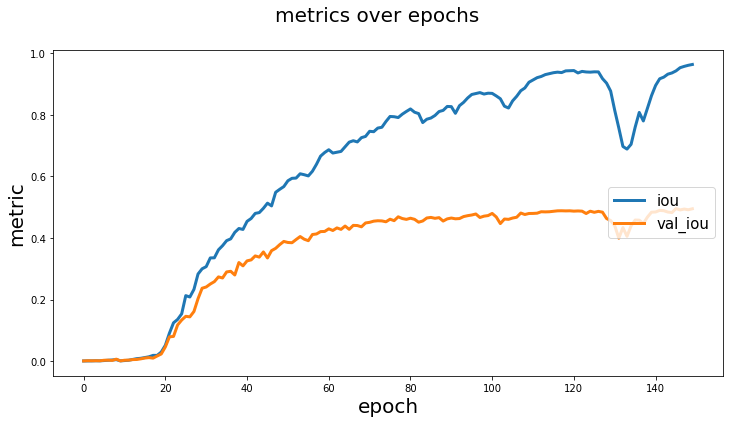

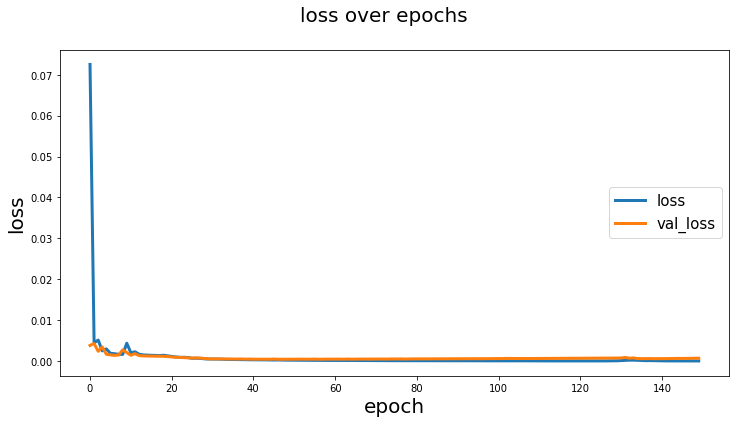

In [20]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [21]:
y_pred = model.predict(X_val)

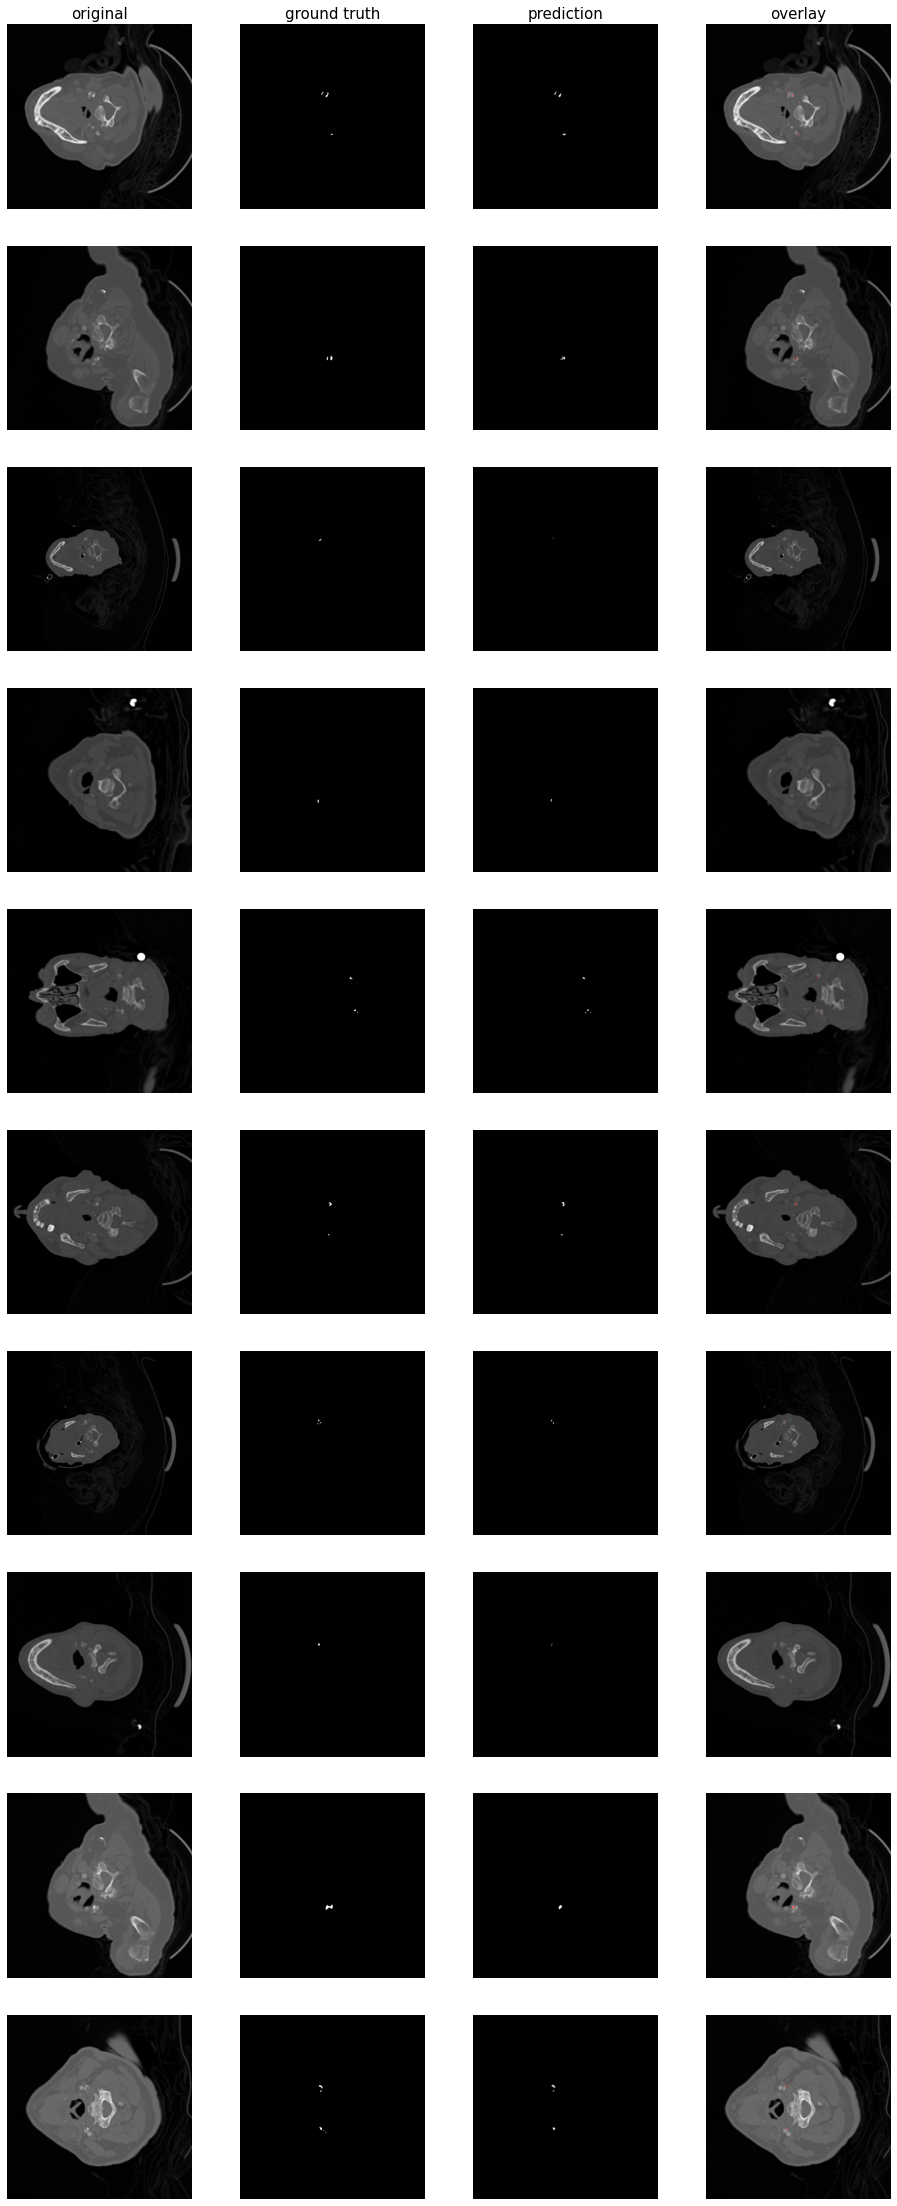

In [22]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [23]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

4/4 [==============================] - 2s 335ms/step - loss: 6.7572e-04 - iou: 0.5032 - iou_thresholded: 0.5127
